1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import mat
from scipy import optimize
from scipy import stats

%matplotlib inline

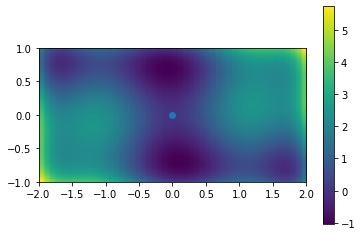

In [28]:
def f(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]
            + (-4 + 4*x[1]**2) * x[1] **2)

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)

x_min = optimize.minimize(f, x0=[0, 0])

plt.figure()
# the function in 2D
plt.imshow(f([xg, yg]), extent=[-2, 2, -1, 1], origin="lower")
plt.colorbar()

# the minimum that we've found:
plt.scatter(x_min.x[0], x_min.x[1])

plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

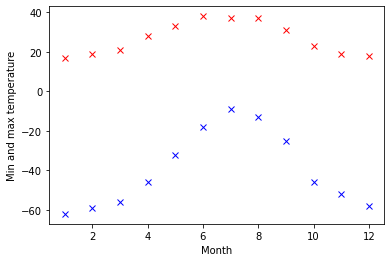

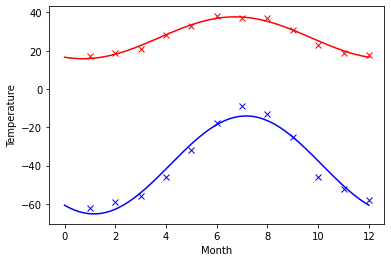

In [39]:
def yearly_temps(times, a, ampl, time_offset):
    return (a + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))


temp_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
temp_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

months = np.arange(12) + 1
plt.plot(months, temp_max, 'rx')
plt.plot(months, temp_min, 'bx')
plt.xlabel('Month')
plt.ylabel('Min and max temperature')

res_max, cov_max = optimize.curve_fit(yearly_temps, months, temp_max, [20, 10, 0])
res_min, cov_min = optimize.curve_fit(yearly_temps, months, temp_min, [-40, 20, 0])

days = np.linspace(0, 12, num=365)

plt.figure()
plt.plot(months, temp_max, 'rx')
plt.plot(days, yearly_temps(days, *res_max), 'r-')
plt.plot(months, temp_min, 'bx')
plt.plot(days, yearly_temps(days, *res_min), 'b-')
plt.xlabel('Month')
plt.ylabel('Temperature')

plt.show()


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [40]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

--2022-01-01 11:47:35--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2022-01-01 11:47:35--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb9c006872667c59880017229c1.dl.dropboxusercontent.com/cd/0/inline/Bc-yipYoXfljFrhJ9E2F0pCRfc4otHu7fq0PEgDNB2VdiOvwMeMD6S7rAdgnApmuB1VlrK3rlokGo3xxI6fPSx_xqv1KHGTqh-_FokW9IyOK6eWlIBJYR1AVGf2tHue7pNmuee3zdSCcB90TyZ4tuD3t/file# [following]
--2022-01-01 11:47:36--  https://ucb9c006872667c59880017229c1.dl.dropboxusercontent.com/cd/0/inline/Bc-yipYoXfljFrhJ9E2F0pCRfc4otHu7fq0PEgDNB2VdiOvwMeMD6S7rAdgnApmuB1VlrK3rlokGo3xxI6fPSx_xqv1KHGTqh-_Fo

In [3]:
import pickle
import pandas as pd

with open('data/residuals_261.pkl.1', 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data.item())

df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


ssr,tss  94467.84312287699 6418333.673469388
R2 = 0.9852815624850783 
R = 0.9926135010592382
Covariance matrix:
 [[ 1.         -0.06244466]
 [-0.06244466  1.        ]]
n degrees of freedom = 48
chi2 = 8912.771466254833
p-value = 0.0


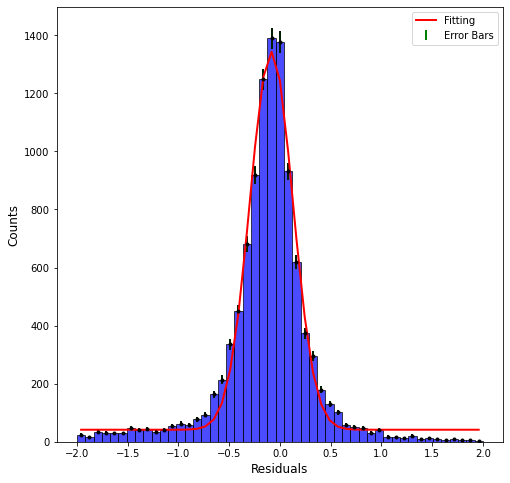

In [49]:
#By looking at the histogram, it is look like Gaussian distribution

def gaussian_dist (x, a, x0, sigma, d): #gaussian distirbution
    gaus = a * np.exp(-(x-x0)**2/(2*sigma**2)) + d
    return gaus

fig, ax = plt.subplots(figsize = (8, 8))
binsx = np.linspace(-2, 2 , 50)

h, bins, _ = ax.hist(df['residuals'], bins = binsx, facecolor = "blue", alpha = 0.7, range = [-25, 25], edgecolor = "black")

binCenter = 0.5 * (bins[1:] + bins[:-1])
binWidth = bins[1] - bins[0]
binErrors = np.sqrt(h)

mean, sigma = stats.norm.fit(h) 
p0 = [max(h), mean, sigma, 0]

popt, pcov = optimize.curve_fit(gaussian_dist, binCenter, h, p0)

ax.errorbar(binCenters, h, binErrors, fmt = 'none', label = "Error Bars", ecolor = "green", linewidth = 2)
ax.plot(binCenter, gaussian_dist(binCenter, *popt), color = 'red', linewidth=2, label = 'Fitting')

ax.set_xlabel("Residuals", fontsize = 12)
ax.set_ylabel("Counts" % binWidth, fontsize = 12)
_ = ax.legend(loc='upper right', markerscale = 1)


## GOODNESS OF FIT

ssr = np.sum((h - (gaussian_dist(binCenter, *tuple(popt))))**2)
tss = np.sum((np.mean(h) - h)**2)

rsq = 1 - ssr / tss

print("ssr,tss ", ssr, tss)
print("R2 =", rsq, "\nR =", np.sqrt(rsq))
print("Covariance matrix:\n", np.corrcoef(binCenter, h)) # check with the correlation matrix that R is the correlation coefficient

sigma_y = np.sqrt(np.abs(h)) 

ax.errorbar(binCenter, h, yerr=sigma_y, fmt='.k') # use plt.errorbar to plot points with the corresponding uncertainties
ndof = len(binCenter) - 1

print("n degrees of freedom =", ndof)

# calculate the chi^2
chi2 = np.sum(((h - (gaussian_dist(binCenter, *tuple(popt))))**2) / sigma_y)
print("chi2 =", chi2)

# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

#Since the p-value = 0 which is smaller than 0.05, the fit is not satisfactory

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [51]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt

--2022-01-19 22:07:32--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [following]
--2022-01-19 22:07:33--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc63eacc88892d48471c7c16b883.dl.dropboxusercontent.com/cd/0/inline/BeHkq0xLuH54AbIhQXa8mgBQOGmbf6Fd8MpbdHL44tGJJmxSTLowPmCgOA2YBcojCAJdjsiak2-dOrLVQA5mNunPfUgUoLh1w5qPPflzdc9EAArEvHNtNiqPjBK12mtQODoedupn93Ja01Jpo-4jHIg-/file# [following]
--2022-01-19 22:07:33--  https://uc63eacc88892d48471c7c16b883.dl.dropboxusercontent.com/cd/0/inline/BeHkq0xLuH54AbIhQ

In [140]:
df1 = pd.read_csv('munich_temperatures_average_with_bad_data.txt.1', delimiter = ' ', header=None, names=['time', 'temperature'])

df1

,time,temperature
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


optimal parameters:  [9.98813368 2.90824505 9.38411487]
The overall average temperature:  8.94190703859861
Coldest temperature:  8.798534084272557
Hottest temperature:  9.053784111013764


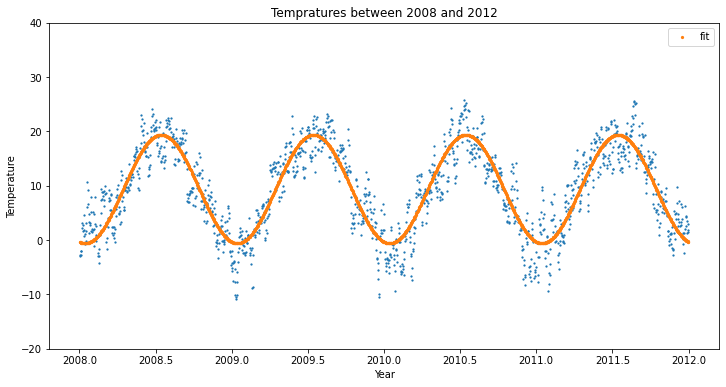

In [141]:
def f(t, a, b, c):
    return a*np.cos(2*np.pi*t + b) + c

df2 = df1[(df1['time'] >= 2008) & (df1['time'] <= 2012)]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Tempratures between 2008 and 2012")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature")
ax.scatter(df2['time'], df2['temperature'], s = 1.5)
ax.set_ylim(-20, 40)

f_popt, f_pcov = optimize.curve_fit(f, df2['time'], df2['temperature'], p0 = [10, 2 , 5])
print("optimal parameters: ", popt)


ax.scatter(df2['time'], f(df2['time'], *popt), label='fit', s=1.5, linewidth=2)
ax.legend()

overallMean = df1['temperature'].mean()
print("The overall average temperature: ", overallMean)

tempCold = df1.groupby('time')['temperature'].min().mean()
tempHot = df1.groupby('time')['temperature'].max().mean()

print("Coldest temperature: ", tempCold)
print("Hottest temperature: ", tempHot)

optimal parameters: [9.98813368 2.90824505 9.38411487]


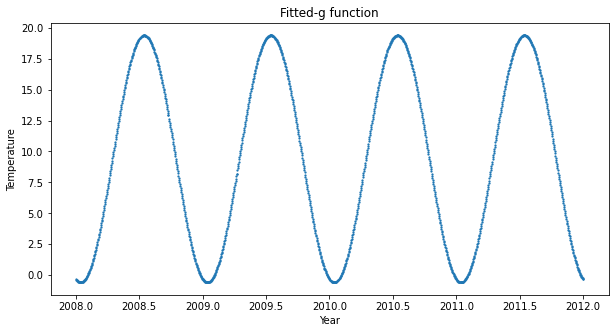

In [142]:
def g(t, a, b, c, d):
    return a*np.cos(2*np.pi*b*t + c) + d # b is define frequency of the cos function

g_popt, g_pcovg = optimize.curve_fit(g, df2['time'], df2['temperature'], p0=[-9, 1, 0, 9])

print("optimal parameters:", popt)

fig, ax_fitted2 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax_fitted2.set_title("Fitted-g function")
ax_fitted2.set_xlabel("Year")
ax_fitted2.set_ylabel("Temperature")
ax_fitted2.scatter(df2['time'] ,g(df2['time'], *g_popt), s=1.5)



In [148]:
# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

rss_1 = np.sum((f(df['time'], *f_popt) - df['temperature'])**2)

rss_2 = np.sum((g(df['time'], *g_popt) - df['temperature'])**2)

print("RSS value for f(x): ", rss_1)
print("RSS value for g(x): ", rss_2)

cl_func_vs_g = Ftest(rss_1, rss_2, 2, 3, len(df['time']), verbose=True)

RSS value for f(x):  34359.85859996652
RSS value for g(x):  34352.794053832025
CL: 0.584 , additional parameter necessary: NO
